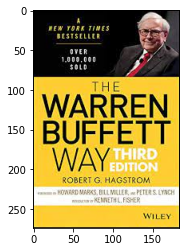

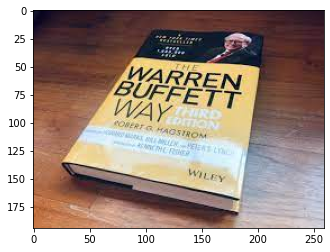

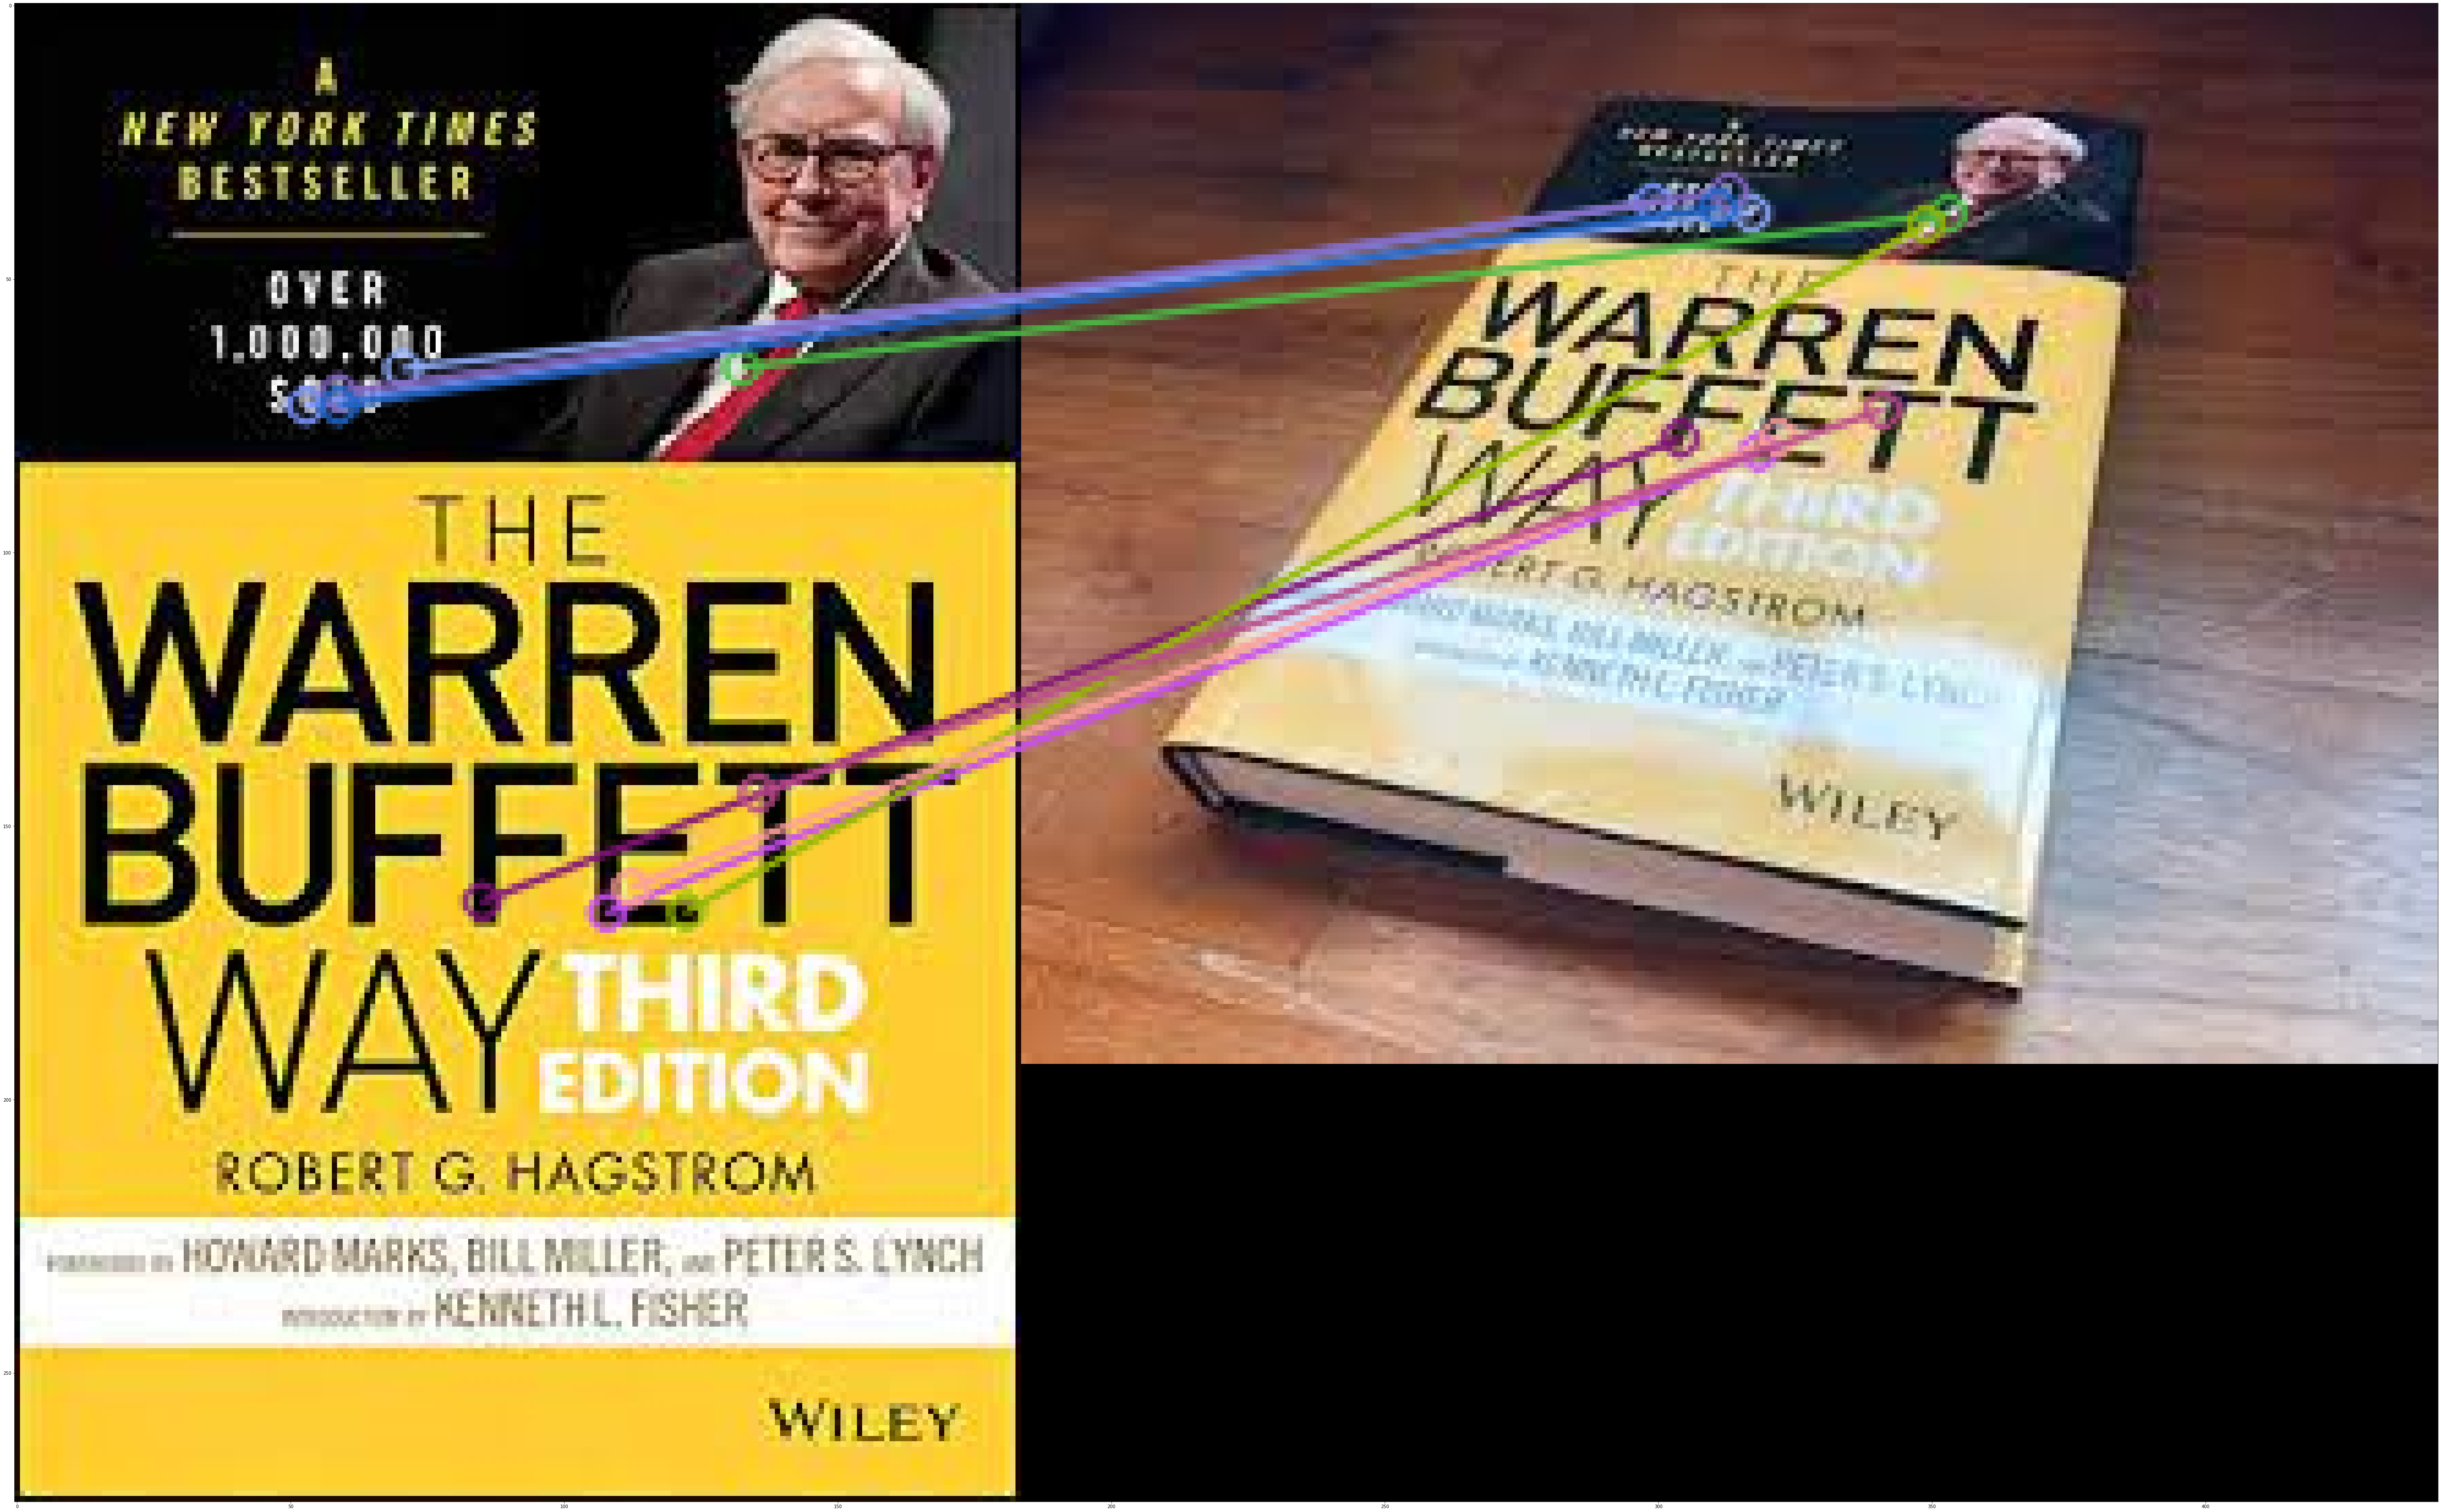

In [7]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

img = cv2.imread('../../Resources/Photos/book.jpg')
rgbimg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

train_img = cv2.imread('../../Resources/Photos/book-test.jpg')
train_rgbimg = cv2.cvtColor(train_img,cv2.COLOR_BGR2RGB)


plt.imshow(rgbimg)
plt.show()


plt.imshow(train_rgbimg)
plt.show()


orb = cv2.ORB_create()

kp1, des1 = orb.detectAndCompute(rgbimg,None)
kp2, des2 = orb.detectAndCompute(train_rgbimg,None)

# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
# Match descriptors.
matches = bf.match(des1,des2)
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)
# Draw first 10 matches.
img3 = cv2.drawMatches(rgbimg,kp1,train_rgbimg,kp2,matches[:10],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize = (100,100))
plt.imshow(img3)
plt.show()



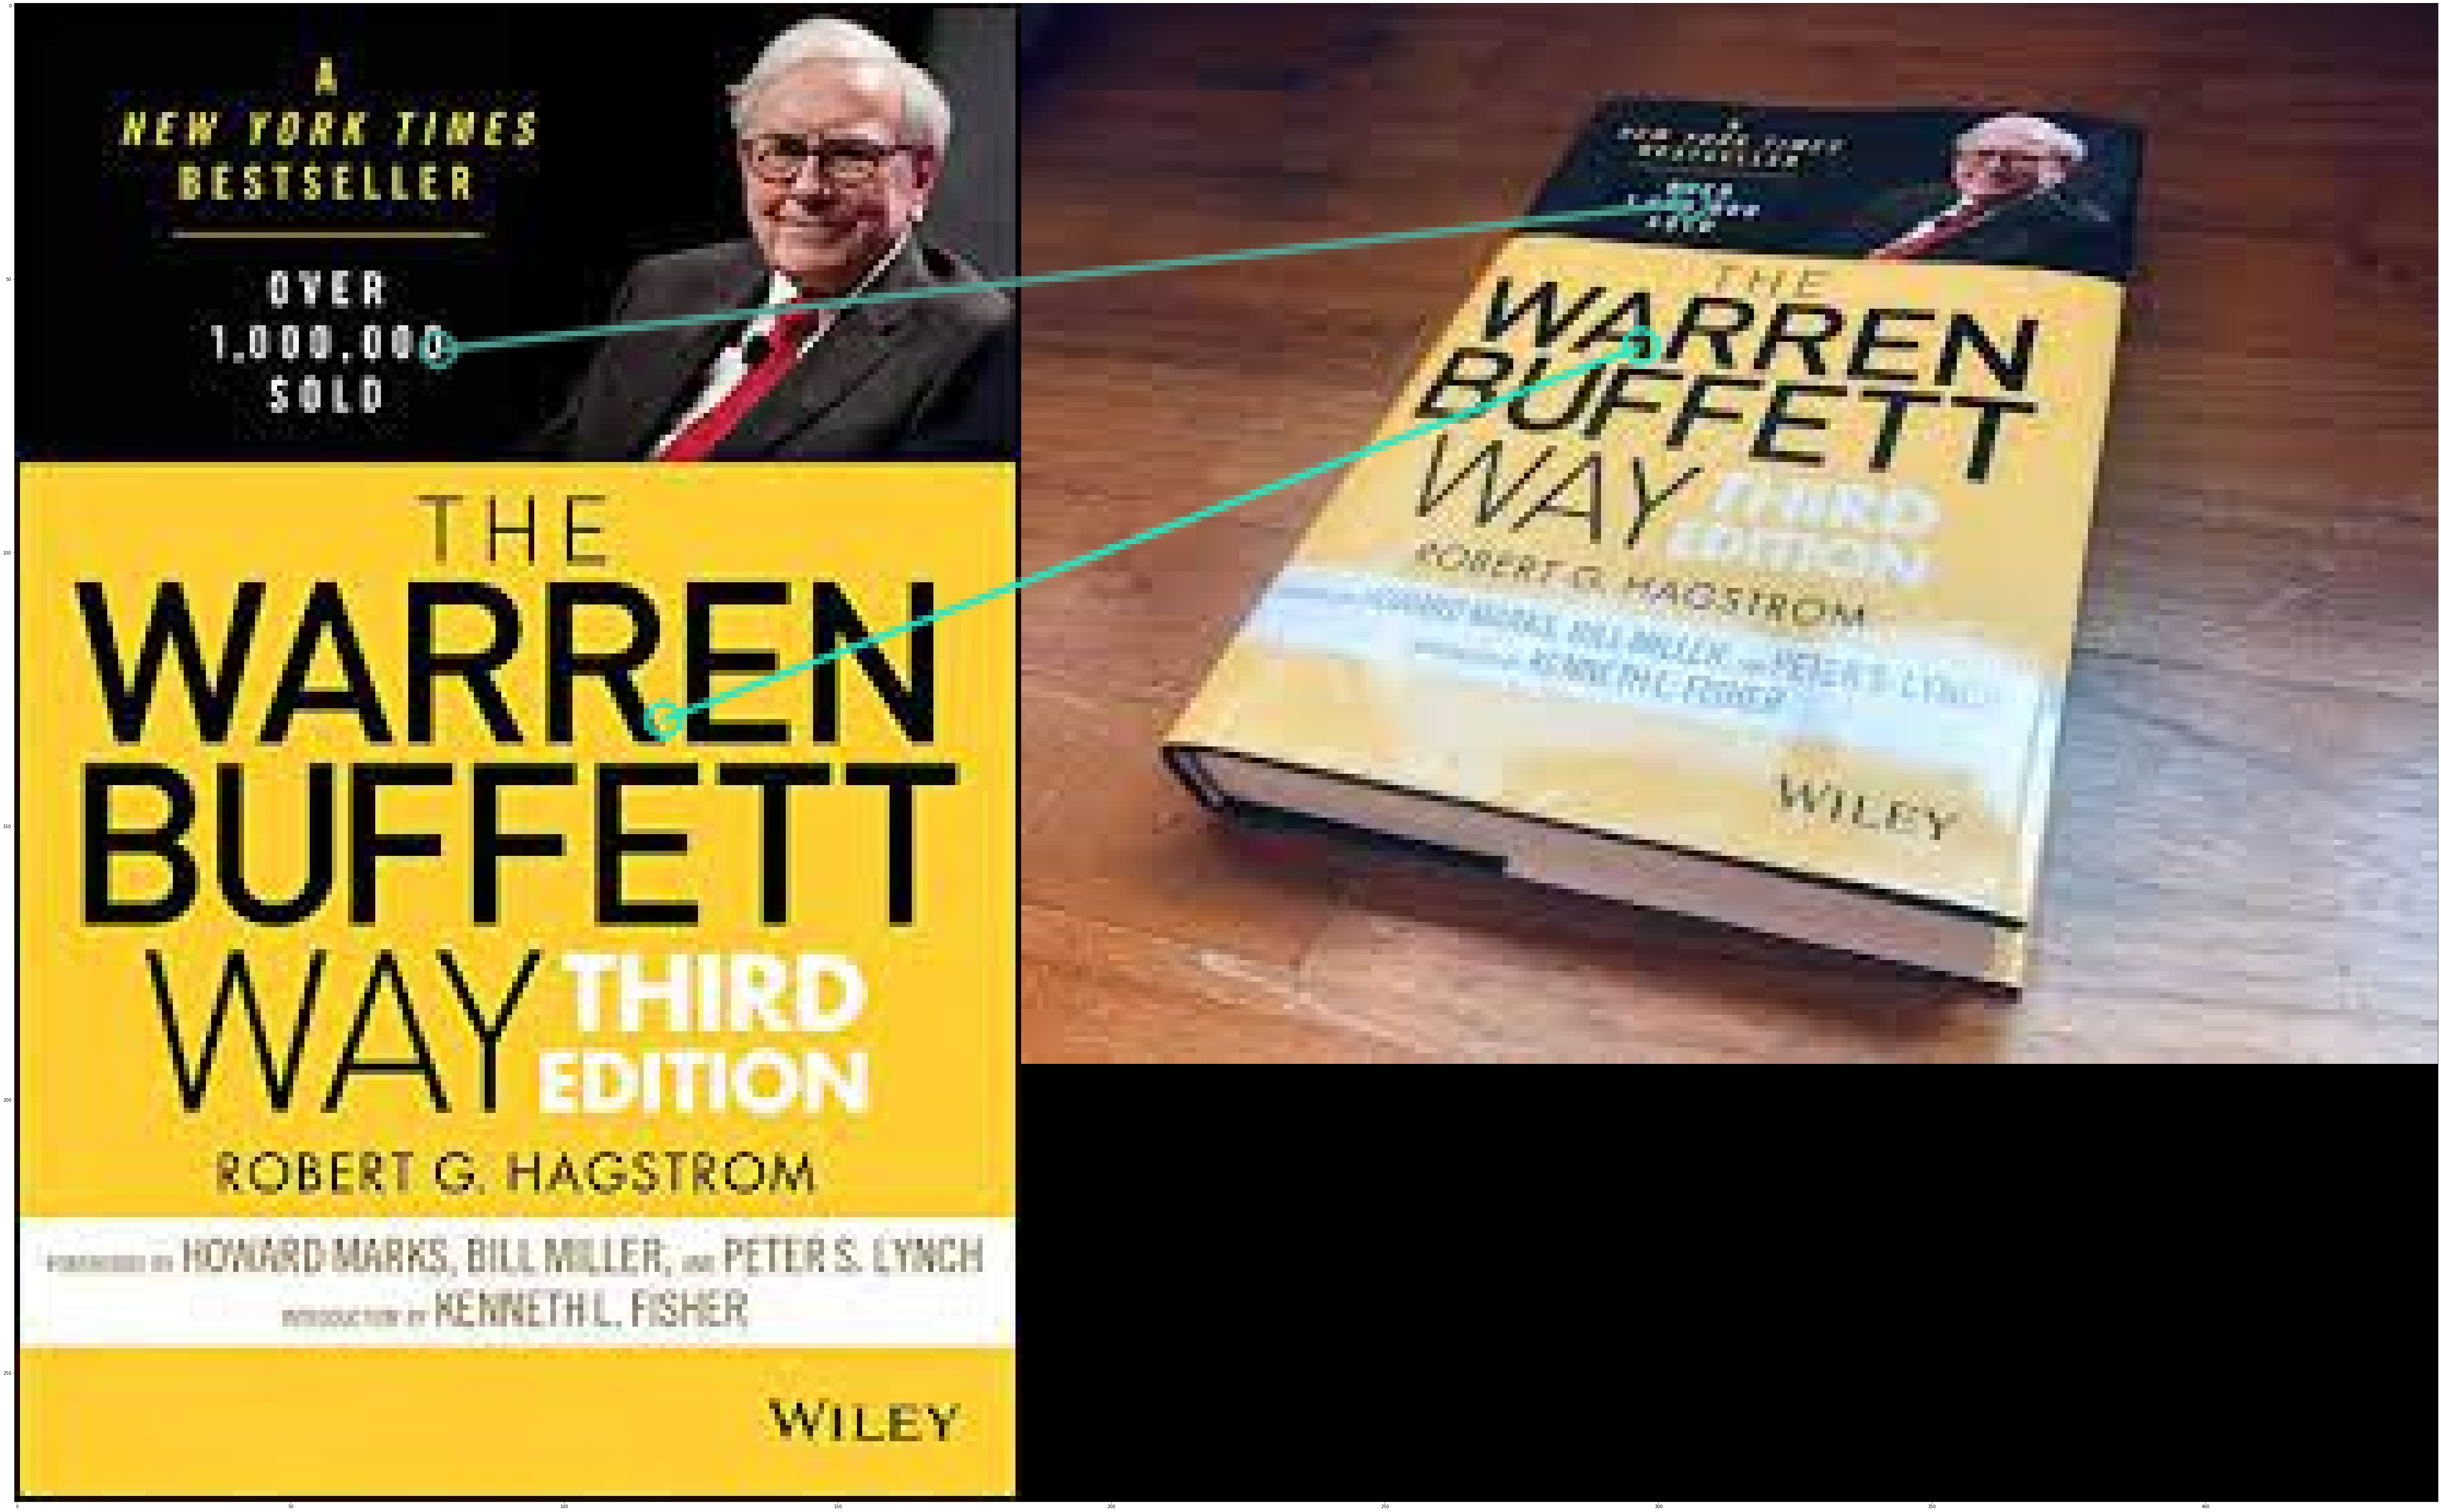

In [8]:
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)
# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])
# cv.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatchesKnn(rgbimg,kp1,train_rgbimg,kp2,good,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize = (100,100))
plt.imshow(img3)
plt.show()

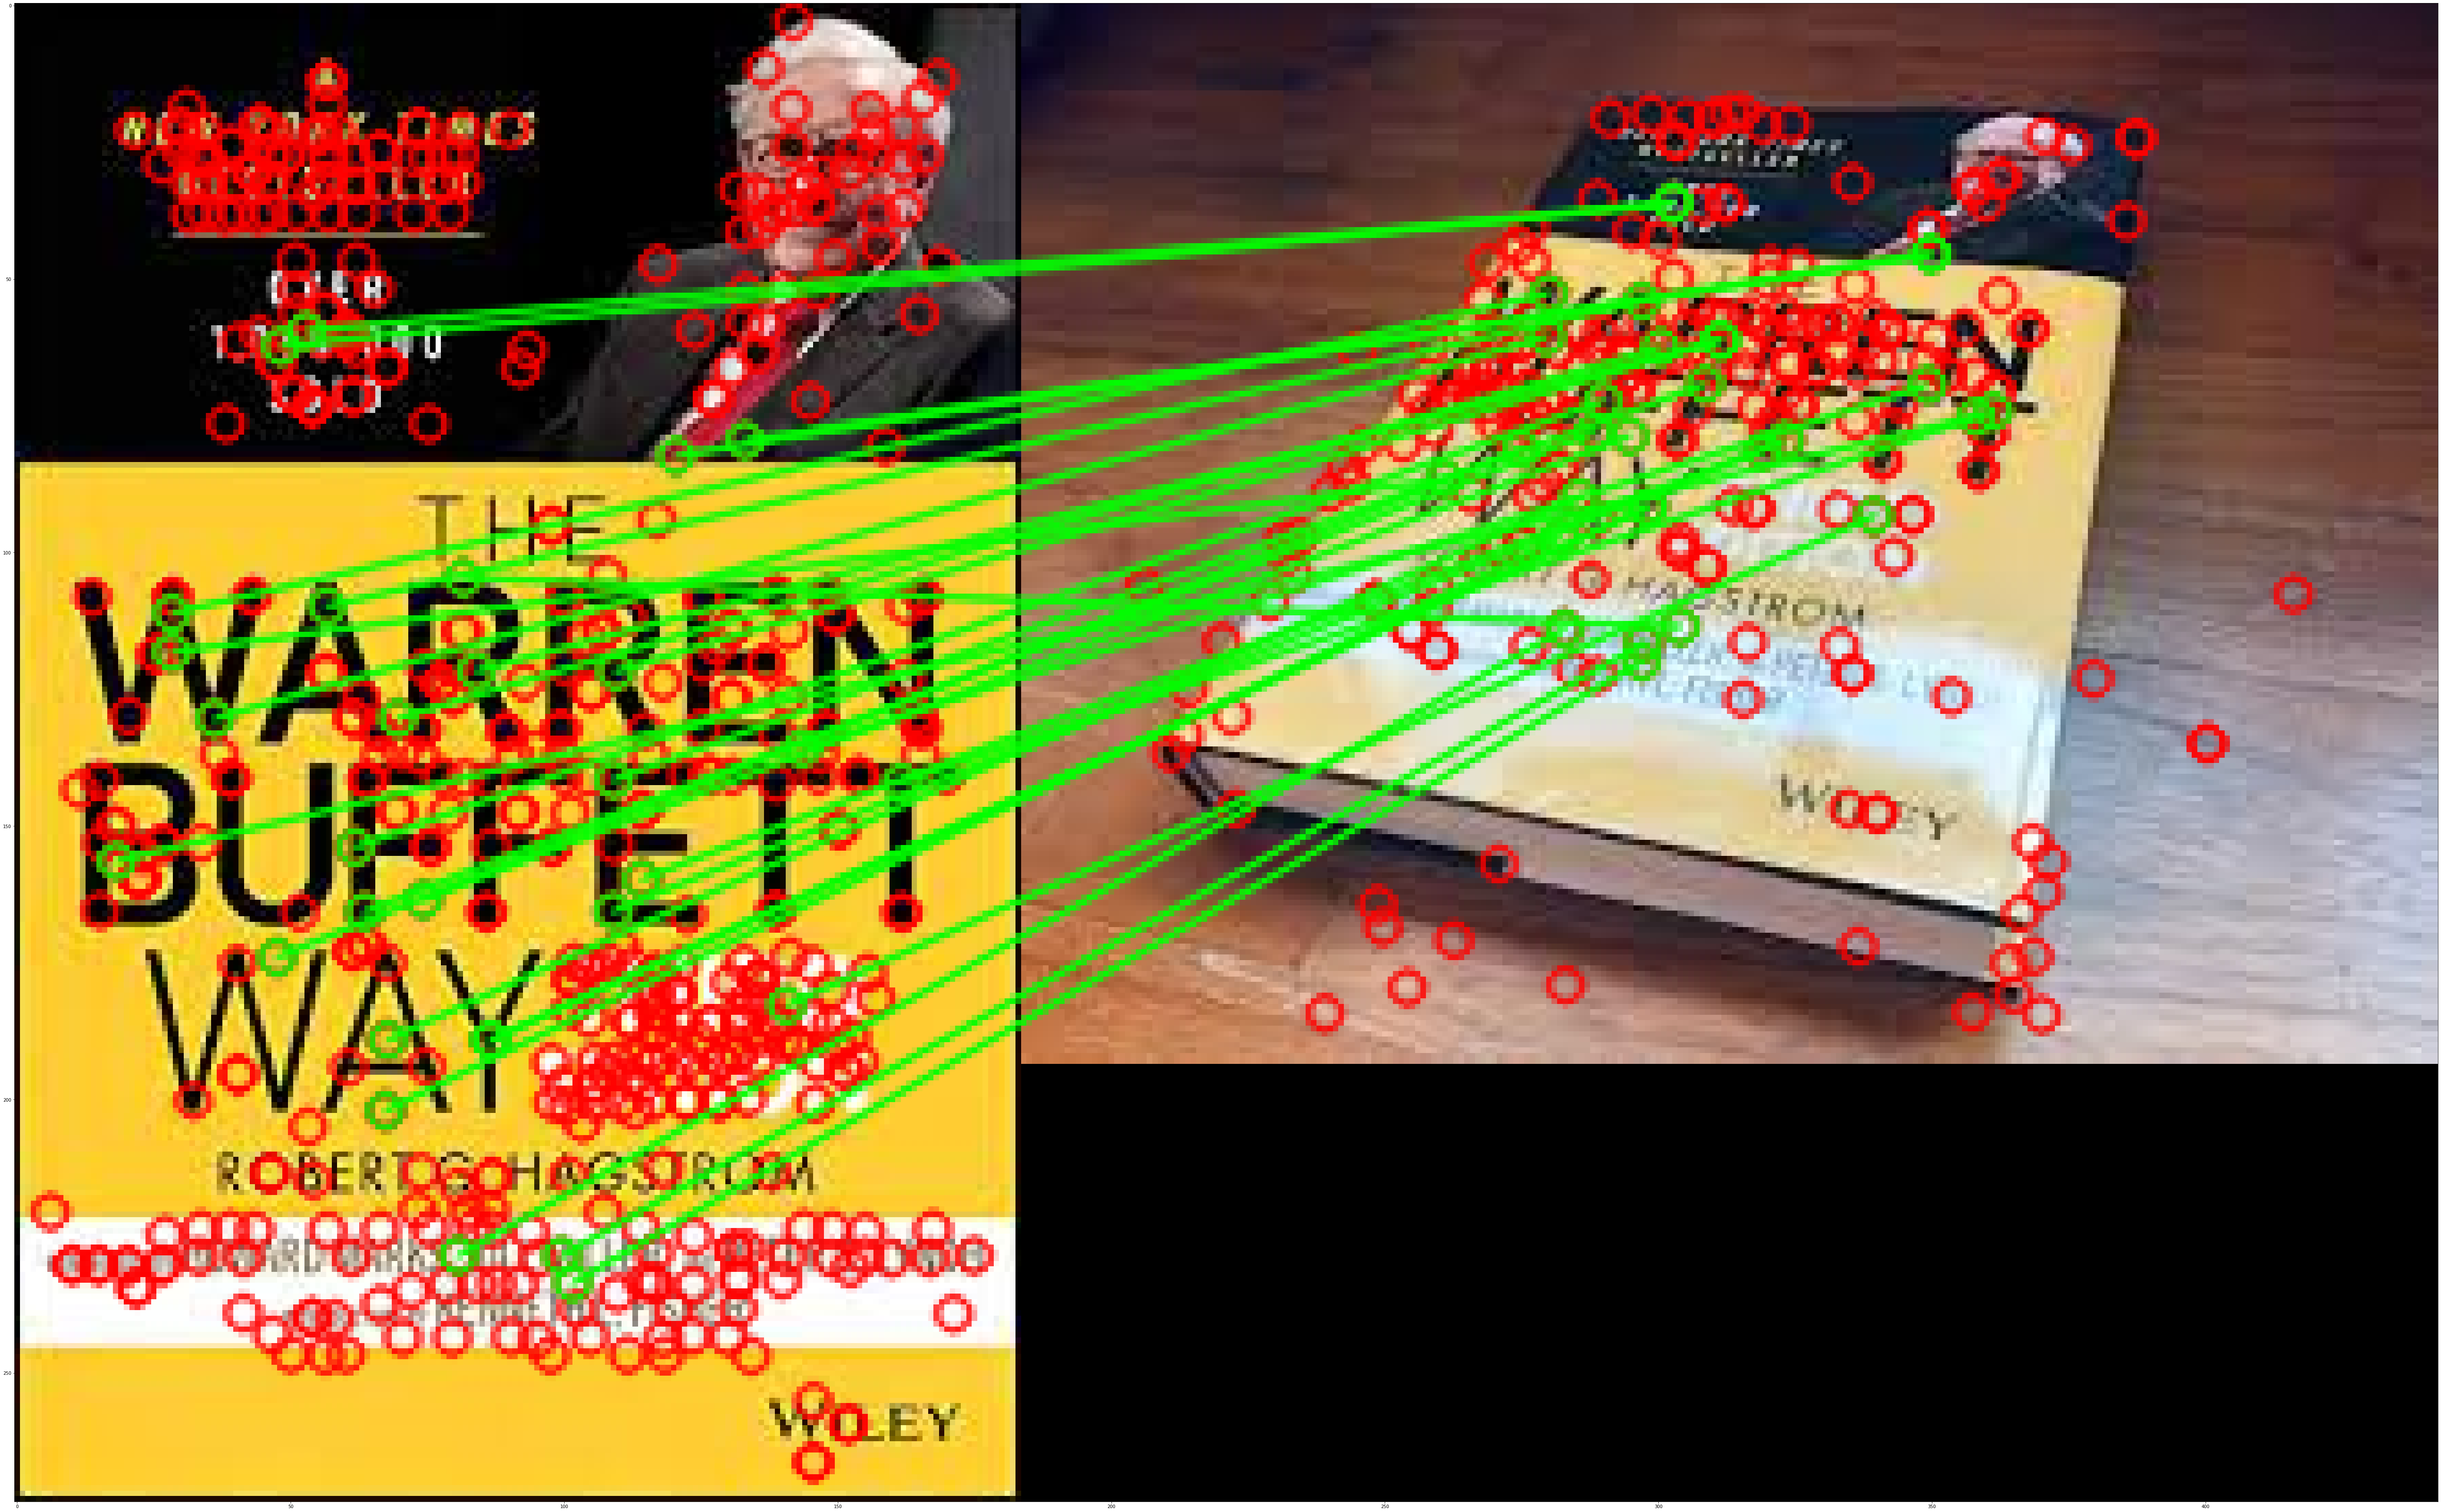

In [9]:
img = cv2.imread('../../Resources/Photos/book.jpg')
rgbimg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

train_img = cv2.imread('../../Resources/Photos/book-test.jpg')
train_rgbimg = cv2.cvtColor(train_img,cv2.COLOR_BGR2RGB)

# train_rgbimg = cv2.cvtColor(train_rgbimg,cv2.COLOR_RGB2GRAY)
# rgbimg = cv2.cvtColor(rgbimg,cv2.COLOR_RGB2GRAY)

sift = cv2.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(rgbimg,None)
kp2, des2 = sift.detectAndCompute(train_img,None)
# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)
# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]


# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i]=[1,0]
draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = cv2.DrawMatchesFlags_DEFAULT)
img3 = cv2.drawMatchesKnn(rgbimg,kp1,train_rgbimg,kp2,matches,None,**draw_params)

plt.figure(figsize = (100,100))
plt.imshow(img3)
plt.show()

In [14]:
MIN_MATCH_COUNT = 10
img = cv2.imread('../../Resources/Photos/book.jpg')
rgbimg = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

train_img = cv2.imread('../../Resources/Photos/book-test.jpg')
train_rgbimg = cv2.cvtColor(train_img,cv2.COLOR_BGR2GRAY)
# Initiate SIFT detector
sift = cv2.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(rgbimg,None)
kp2, des2 = sift.detectAndCompute(train_rgbimg,None)
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)
# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

In [15]:
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    h,w = rgbimg.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)
    img2 = cv2.polylines(train_rgbimg,[np.int32(dst)],True,255,3, cv2.LINE_AA)
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

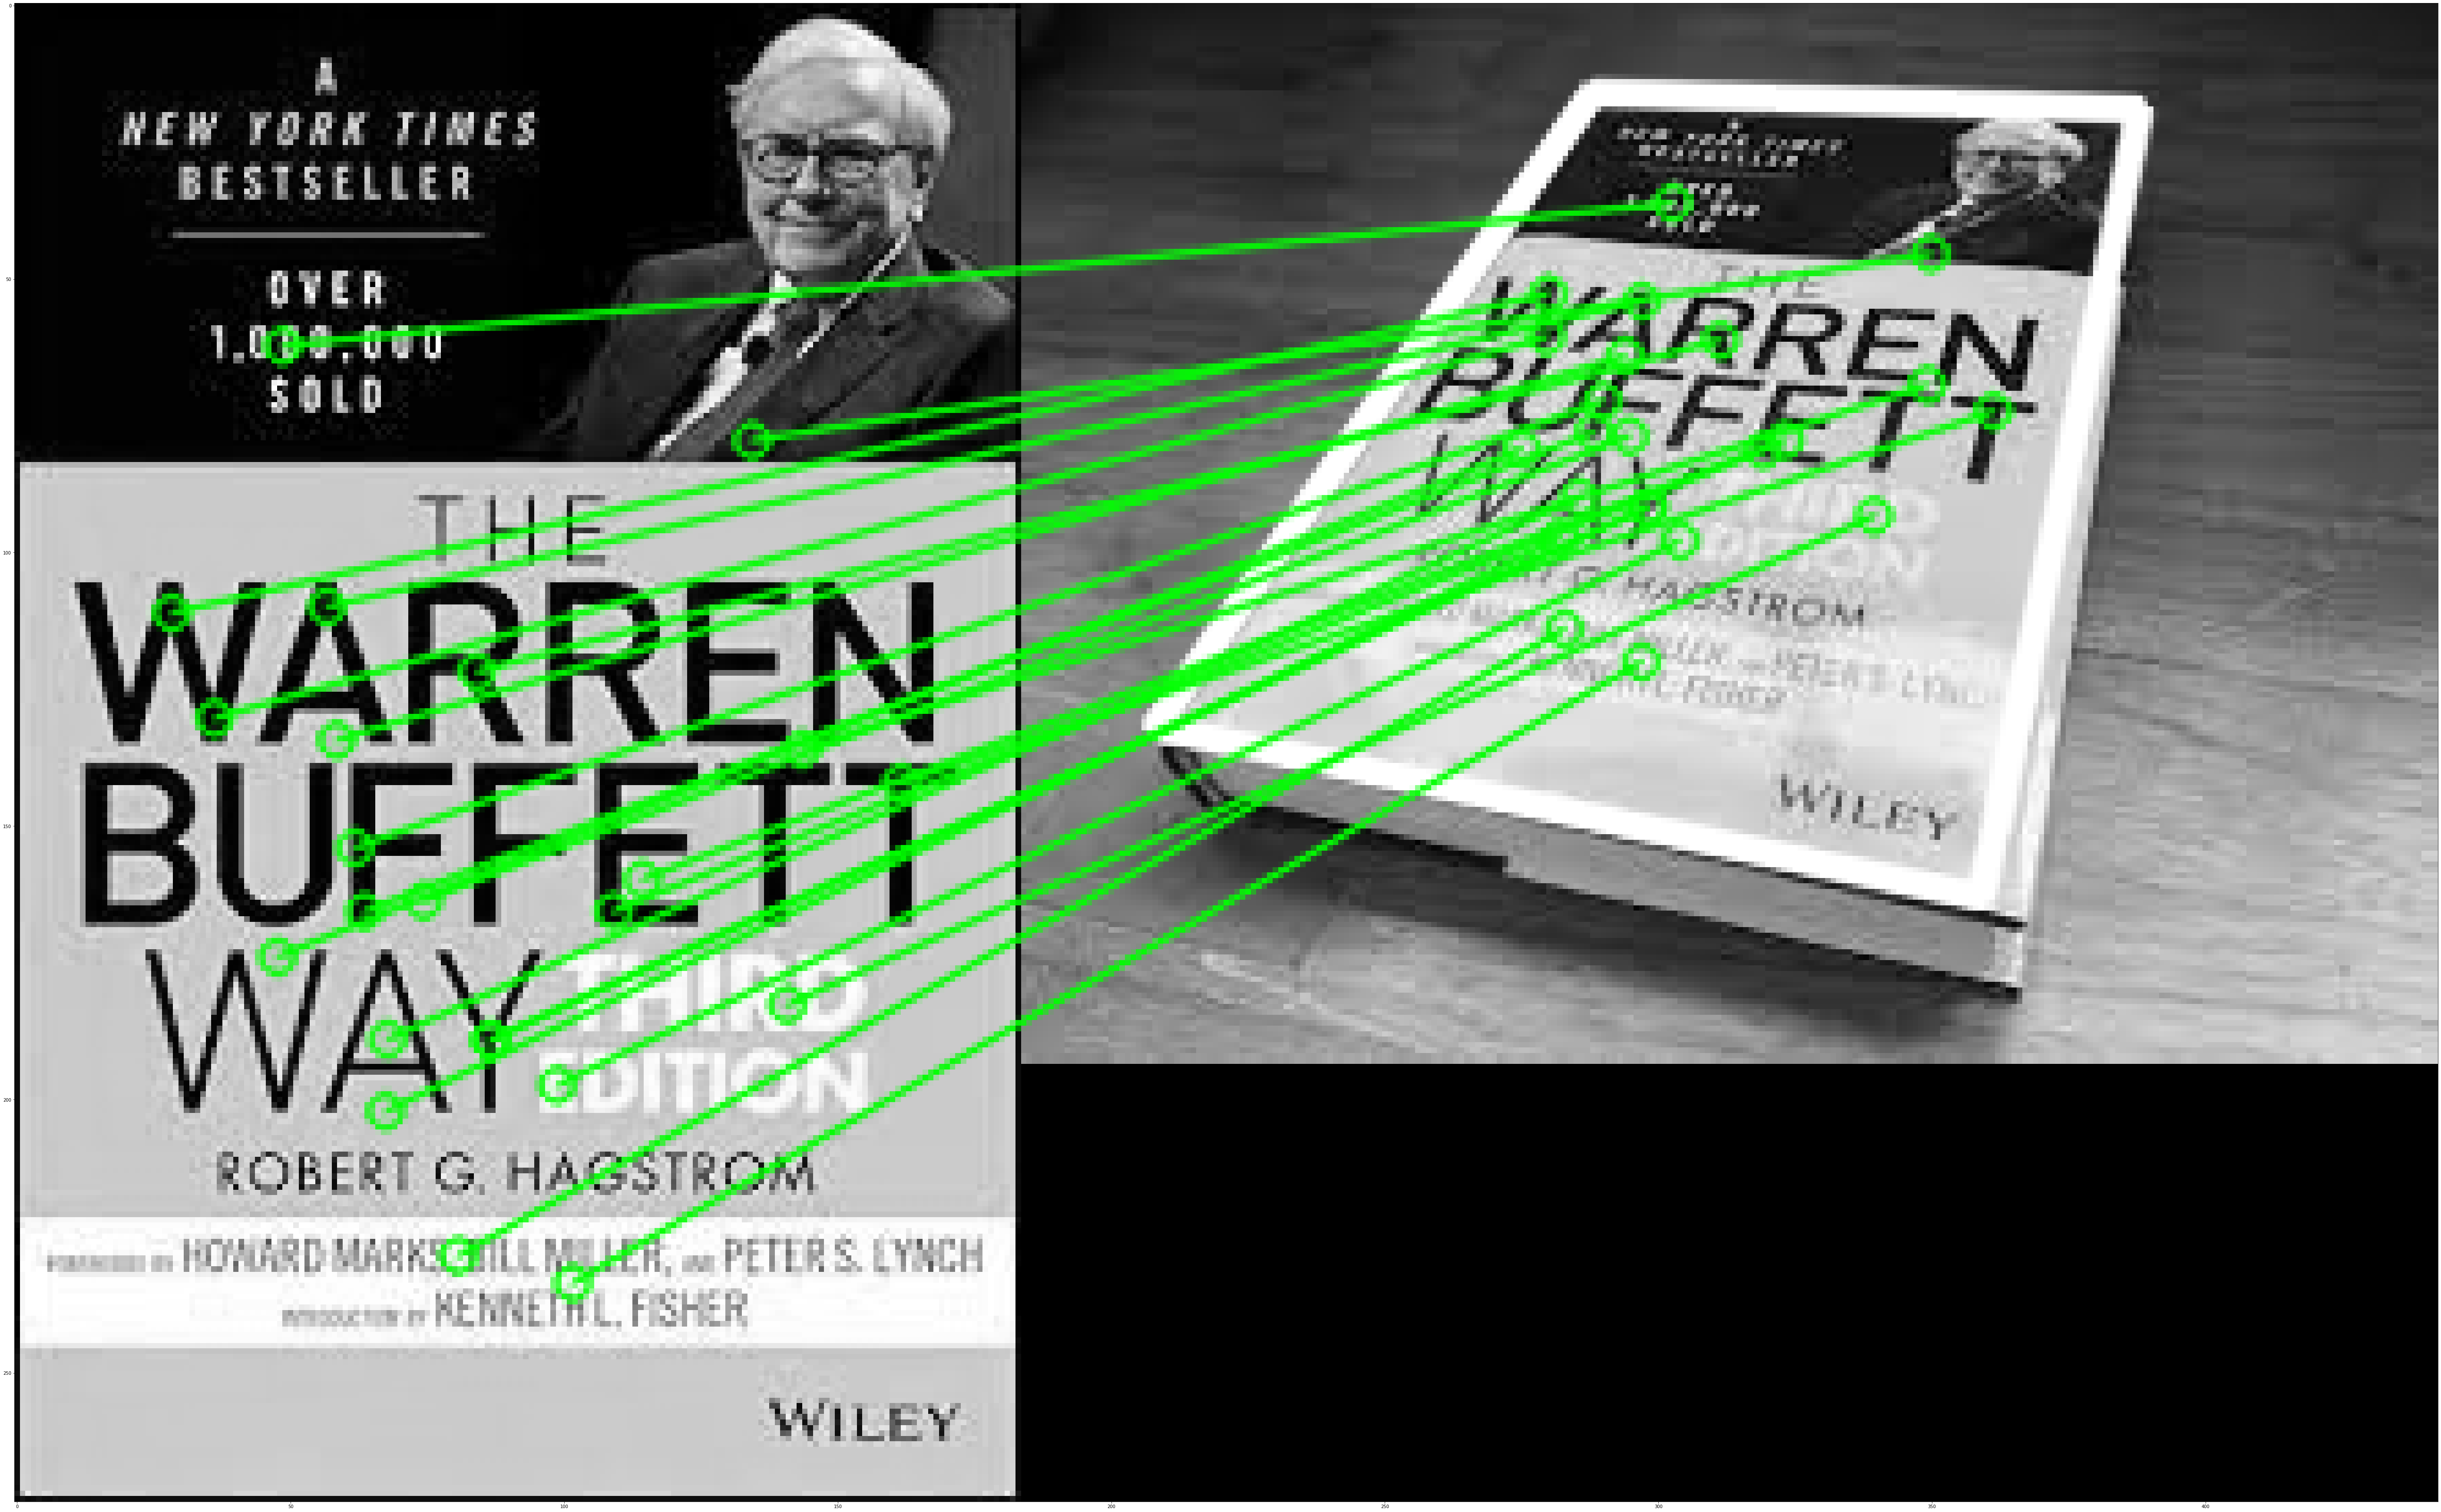

In [16]:
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
img3 = cv2.drawMatches(rgbimg,kp1,img2,kp2,good,None,**draw_params)

plt.figure(figsize = (100,100))
plt.imshow(img3)
plt.show()